# Кибериммунный подход к разработке

## Демонстрация FLASK подхода

1. Создадим две сущности и монитор, который будет контролировать их взаимодействие
2. Определим политики безопасности
3. Отправим простой запрос для проверки работы всех элементов

- Каждая сущность WorkerA, WorkerB, Monitor (монитор безопасности) в качестве интерфейса использует очереди сообщений, у каждой сущности есть своя «персональная» очередь, ассоциированная с ней
- WorkerA и WorkerB отправляют сообщения только в очередь Monitor
- Monitor проверяет сообщения на соответствие политикам безопасности, в случае положительного решения перенаправляет сообщение в очередь соответствующей сущности

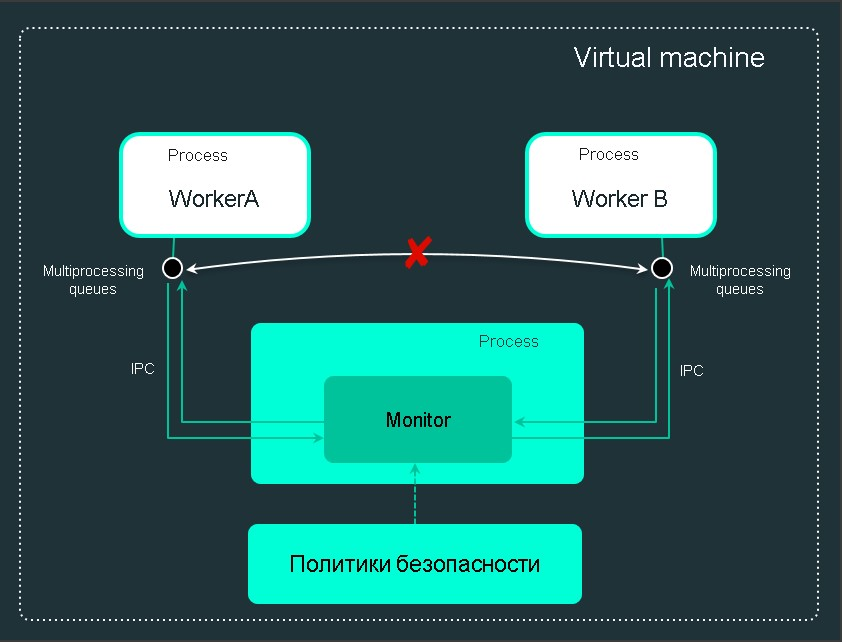

Очередь событий для монитора безопасности: все запросы от сущностей друг к другу должны отправляться только в неё

In [37]:
from multiprocessing import Queue

monitor_events_queue = Queue()

Зафиксируем формат сообщений

In [38]:
from dataclasses import dataclass


@dataclass
class Event:
    source: str       # отправитель
    destination: str  # получатель
    operation: str    # чего хочет (запрашиваемое действие)
    parameters: str   # с какими параметрами

### Монитор безопасности

In [39]:
from multiprocessing import Queue, Process
from multiprocessing.queues import Empty


# формат управляющих команд для сущностей
@dataclass
class ControlEvent:
    operation: str


# Класс, реализующий поведение монитора безопасности
class Monitor(Process):

    def __init__(self, events_q: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self._events_q = events_q  # очередь событий для монитора (входящие сообщения)
        self._control_q = Queue()  # очередь управляющих команд (например, для остановки монитора)
        self._entity_queues = {}   # словарь очередей известных монитору сущностей
        self._force_quit = False   # флаг завершения работы монитора

    # регистрация очереди новой сущности
    def add_entity_queue(self, entity_id: str, queue: Queue):
        print(f"[монитор] регистрируем сущность {entity_id}")
        self._entity_queues[entity_id] = queue

    # проверка политик безопасности
    # метод статический, т.к. не использует никакие внутренние переменные класса
    @staticmethod
    def _check_policies(event):
        print(f'[монитор] обрабатываем событие {event}')

        # default deny: всё, что не разрешено, запрещено по умолчанию!
        authorized = False

        # проверка на входе, что это экземпляр класса Event, 
        # т.е. имеет ожидаемый формат
        if not isinstance(event, Event):
            return False

        # 
        #  политики безопасности
        #

        # пример политики безопасности
        if event.source == "Operator" \
            and event.destination == "ControlSystem" \
            and event.operation in ["increase temperature", "open reactor"]:
            
            authorized = True

        if event.source == "ControlSystem" \
            and event.destination in ["SecuritySystem", "Operator"] \
            and event.operation in ["increase temperature", "open reactor"]:
            
            authorized = True

        if event.source == "ControlSystem" \
            and event.destination in ["SecuritySystem", "Operator"] \
            and event.operation == "shutdown reactor" \
            and event.parameters in ["regular", "emergency"]:
            
            authorized = True

        if  event.source == "SecuritySystem" \
            and event.destination == "ControlSystem" \
            and event.operation in ["increase temperature", "open reactor"]:

            authorized = True

        if  event.source == "SecuritySystem" \
            and event.destination == "ControlSystem" \
            and event.operation == "shutdown reactor" \
            and event.parameters in ["regular", "emergency"]:

            authorized = True
            

        if authorized:
            print(f"[монитор] событие от {event.source} к {event.destination} разрешено политиками безопасности")
        else:
            print(f"[монитор] событие не разрешено политиками безопасности")
        return authorized

    # выполнение разрешённого запроса
    # метод должен вызываться только после проверки политик безопасности
    def _proceed(self, event):
        print(f'[монитор] отправляем запрос {event}')
        try:
            # найдём очередь получателя события
            dst_q: Queue = self._entity_queues[event.destination]
            # и положим запрос в эту очередьand event.parameters in ["regular", "emergency"]
        except  Exception as e:
            # например, запрос пришёл от или для неизвестной сущности
            # например, запрос пришёл от или для неизвестной сущности
            print(f"[монитор] ошибка выполнение запроса {e}")

    # основной код работы монитора безопасности    
    def run(self):
        print(f'[монитор] старт')

        # в цикле проверяет наличие новых событий, 
        # выход из цикла по флагу _force_quit
        while self._force_quit is False:
            event = None
            try:
                # ожидание сделано неблокирующим, 
                # чтобы можно было завершить работу монитора, 
                # не дожидаясь нового сообщения
                event = self._events_q.get_nowait()
                # сюда попадаем только в случае получение события,
                # теперь нужно проверить политики безопасности
                authorized = self._check_policies(event)
                if authorized:
                    # если политиками запрос авторизован - выполняем
                    self._proceed(event)
            except Empty:
                # сюда попадаем, если новых сообщений ещё нет,
                # в таком случае немного подождём
                sleep(0.5)
            except Exception as e:
                # что-то пошло не так, выведем сообщение об ошибке
                print(f"[{self.__class__.__name__}] ошибка обработки {e}, {event}")
            self._check_control_q()
        print(f'\n[{self.__class__.__name__}] завершение работы')

    # запрос на остановку работы монитора безопасности для завершения работы
    # может вызываться вне процесса монитора
    def stop(self):
        # поскольку монитор работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса монитора
        request = ControlEvent(operation='stop')
        self._control_q.put(request)

    # проверка наличия новых управляющих команд
    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == 'stop':
                # поступил запрос на остановку монитора, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило, ну и ладно
            pass

### Сущность Оператор (Operator)

Оператор отправляет системе контроля управляющие команды и получает от нее обратную связь

In [40]:
from multiprocessing import Queue, Process
from time import sleep


class Operator(Process):

    def __init__(self, monitor_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        # мы знаем только очередь монитора безопасности для взаимодействия с другими сущностями
        # прямая отправка сообщений в другую сущность запрещена в концепции FLASK
        self.monitor_queue = monitor_queue
        # создаём собственную очередь, в которую монитор сможет положить сообщения для этой сущности
        self._own_queue = Queue()
        self._control_q = Queue() 
        self._force_quit = False


    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue
    

    def send_request(self, destination, operation, parameters):
        event = Event(source=self.__class__.__name__,
                      destination=destination,
                      operation=operation,
                      parameters=parameters
                     )
        print(f'\n[{self.__class__.__name__}] отправляем запрос {operation} для {destination}')
        self.monitor_queue.put(event)


    # основной код сущности
    def run(self):        
        print(f'\n[{self.__class__.__name__}] старт')
        #print(f'\n[{self.__class__.__name__}] отправляем тестовый запрос')
        while self._force_quit is False:
            event = None
            try:

                event: Event = self._own_queue.get_nowait()
                if event.operation == "increase temperature" and event.source == "ControlSystem":
                    if event.parameters == "success":
                        print(f"[{self.__class__.__name__}] {event.source} сигнализирует об успешном изменении температуры на {event.parameters}")
                    else:
                        print(f"[{self.__class__.__name__}] {event.source} сигнализирует о неуспешном изменении температуры на {event.parameters}")
                if event.operation == "open reactor" and event.source == "ControlSystem":
                    if event.parameters == 'OK':
                        print(f"[{self.__class__.__name__}] {event.source} сигнализирует об успешном открытии крышки реактора")
                    else:
                        print(f"[{self.__class__.__name__}] {event.source} сигнализирует о неуспешном открытии крышки реактора")
            except Empty:
                sleep(0.5)
            except Exception as e:
                # что-то пошло не так, выведем сообщение об ошибке
                print(f"[{self.__class__.__name__}] ошибка обработки {e}, {event}")
            self._check_control_q()
        
        print(f'\n[{self.__class__.__name__}] завершение работы')


    def stop(self):
        # поскольку монитор работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса монитора
        request = ControlEvent(operation='stop')
        self._control_q.put(request)


    # проверка наличия новых управляющих команд
    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == 'stop':
                # поступил запрос на остановку монитора, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило, ну и ладно
            pass

### Сущность Система контроля (ControlSystem)

Система контроля ожидает входящее сообщение в течение заданного периода времени, если получает - обрабатывает.

In [41]:
from multiprocessing import Queue, Process
from time import sleep


class ControlSystem(Process):

    def __init__(self, monitor_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        # мы знаем только очередь монитора безопасности для взаимодействия с другими сущностями
        # прямая отправка сообщений в другую сущность запрещена в концепции FLASK
        self.monitor_queue = monitor_queue
        # создаём собственную очередь, в которую монитор сможет положить сообщения для этой сущности
        self._own_queue = Queue()
        self._control_q = Queue() 
        self._force_quit = False
        self._temperature = 450 # температура реактора
        self._reactor_running = True

    def entity_queue(self):
        return self._own_queue
    
    def send_request(self, destination, operation, parameters):
        event = Event(source=self.__class__.__name__,
                      destination=destination,
                      operation=operation,
                      parameters=parameters
                     )
        print(f'\n[{self.__class__.__name__}] отправляем запрос {operation} для {destination}')
        self.monitor_queue.put(event)
        sleep(0.1)

    def __shutdown_reactor(self, emergency):
        if emergency:
            self._reactor_running = False
        else:
            # штатное отключение
            pass

    # основной код сущности
    def run(self):        
        print(f'\n[{self.__class__.__name__}] старт')
        while self._force_quit is False:
            event = None
            try:

                event: Event = self._own_queue.get_nowait()
                if event.source == "Operator":
                    if event.operation == "increase temperature":
                        print(f"[{self.__class__.__name__}] {event.source} хочет, изменить температуру на {event.parameters}")
                        # запрос для системы безопасности - "можем ли поднять температуру"
                        self.send_request('SecuritySystem', 'increase temperature', f'{self._temperature}:{event.parameters}')

                    if event.operation == "open reactor":
                        print(f"[{self.__class__.__name__}] {event.source} хочет открыть крышку реактора")
                        # запрос для системы безопасности - "можем ли открыть крышку, отправляем статус работы реактора"
                        self.send_request('SecuritySystem', 'open reactor', f'{self._reactor_running}')


                if event.source == "SecuritySystem":
                    if event.operation == "increase temperature":
                        if event.parameters == "OK":
                            print(f"[{self.__class__.__name__}] {event.source} сигнализирует, что можем изменить температуру на {event.parameters}")
                            print(f"[{self.__class__.__name__}] Отправляем подтверждение Оператору")
                            self.send_request('Operator', "increase temperature", "success")
                        else:
                            print(f"[{self.__class__.__name__}] {event.source} сигнализирует, что НЕ можем изменить температуру на {event.parameters}")
                            print(f"[{self.__class__.__name__}] Отправляем ответ Оператору")
                            self.send_request('Operator', "increase temperature", "failure")

                    if event.operation == "open reactor":
                        if event.parameters == 'OK':
                            print(f"[{self.__class__.__name__}] {event.source} сигнализирует об успешном открытии крышки реактора")
                            print(f"[{self.__class__.__name__}] Отправляем подтверждение Оператору")
                            self.send_request('Operator', "open reactor", "success")
                        else:
                            print(f"[{self.__class__.__name__}] {event.source} сигнализирует о том, что не можем открыть крышку реактора")
                            print(f"[{self.__class__.__name__}] Отправляем ответ Оператору")
                            self.send_request('Operator', "open reactor", "failure")

                    if event.operation == "shutdown reactor" and event.parameters == "emergency":
                        print(f"[{self.__class__.__name__}] {event.source} сигнализирует об экстренной остановке реактора")
                        print(f"[{self.__class__.__name__}] Останавливаем реактор")
                        self.__shutdown_reactor(True)
                        print(f"[{self.__class__.__name__}] Отправляем оповещение Оператору")
                        self.send_request('Operator', "shutdown reactor", "emergency")
            except Empty:
                sleep(0.5)
            except Exception as e:
                # что-то пошло не так, выведем сообщение об ошибке
                print(f"[C{self.__class__.__name__}] ошибка обработки {e}, {event}")
            self._check_control_q()
        print(f'\n[{self.__class__.__name__}] завершение работы')

    def stop(self):
        # поскольку монитор работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса монитора
        request = ControlEvent(operation='stop')
        self._control_q.put(request)

    # проверка наличия новых управляющих команд
    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == 'stop':
                # поступил запрос на остановку монитора, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило, ну и ладно
            pass

### Система физическо безопасности (SecuritySystem)
Проверяет все операции на предмет возможности их выполнения, если невозможно выполнить - дает отказ

In [42]:
from multiprocessing import Queue, Process
from time import sleep


class SecuritySystem(Process):

    def __init__(self, monitor_queue: Queue):
        super().__init__()
        self.monitor_queue = monitor_queue
        # создаём собственную очередь, в которую монитор сможет положить сообщения для этой сущности
        self._own_queue = Queue()
        self._control_q = Queue() 
        self._force_quit = False
        self.__temp_limit = 600

    def entity_queue(self):
        return self._own_queue
    
    def send_request(self, destination, operation, parameters):
        event = Event(source=self.__class__.__name__,
                      destination=destination,
                      operation=operation,
                      parameters=parameters
                     )
        print(f'\n[{self.__class__.__name__}] отправляем запрос {operation} для {destination}')
        self.monitor_queue.put(event)
        sleep(0.1)

    # основной код сущности
    def run(self):        
        print(f'\n[{self.__class__.__name__}] старт')
        while self._force_quit is False:
            event = None
            try:
                
                event: Event = self._own_queue.get_nowait()
                if event.source == "ControlSystem":
                    if event.operation == "increase temperature":
                        current_temp, increase_temp = [int(x) for x in event.parameters.split(':')]
                        print(f"[{self.__class__.__name__}] {event.source} запрашивает, изменение температуры {current_temp} на {increase_temp}")
                        
                        if current_temp + increase_temp < self.__temp_limit:
                            
                            print(f"[{self.__class__.__name__}] Изменение возможно. Отправляем ответ системе контроля")
                            self.send_request("ControlSystem", "increase temperature", "OK")
                        else:
                            print(f"[{self.__class__.__name__}] Изменение невозможно. Отправляем ответ системе контроля")
                            self.send_request('ControlSystem', "increase temperature", "X")

                    if event.operation == "open reactor":
                        print(f"[{self.__class__.__name__}] {event.source} запрашивает открытие крышки реактора")
                        if event.parameters == 'True':
                            print(f"[{self.__class__.__name__}] Открыть невозможно, реактор работает")
                            print(f"[{self.__class__.__name__}] Отправляем ответ системе контроля")
                            self.send_request('ControlSystem', "open reactor", "X")
                        else:
                            print(f"[{self.__class__.__name__}] Можем открыть, реактор остановлен")
                            print(f"[{self.__class__.__name__}] Отправляем ответ системе контроля")
                            self.send_request('ControlSystem', "open reactor", "OK")
            except Empty:
                sleep(0.5)
            except Exception as e:
                # что-то пошло не так, выведем сообщение об ошибке
                print(f"[{self.__class__.__name__}] ошибка обработки {e}, {event}")
            self._check_control_q()

        print(f'\n[{self.__class__.__name__}] завершение работы')

    def stop(self):
        # поскольку монитор работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса монитора
        request = ControlEvent(operation='stop')
        self._control_q.put(request)

    # проверка наличия новых управляющих команд
    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == 'stop':
                # поступил запрос на остановку монитора, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило, ну и ладно
            pass

### Инициализируем монитор и сущности

In [43]:
monitor = Monitor(monitor_events_queue)
operator = Operator(monitor_events_queue)
control_sys = ControlSystem(monitor_events_queue)
security_sys = SecuritySystem(monitor_events_queue)

регистрируем очереди сущностей в мониторе

In [44]:
monitor.add_entity_queue(operator.__class__.__name__, operator.entity_queue())
monitor.add_entity_queue(control_sys.__class__.__name__, control_sys.entity_queue())
monitor.add_entity_queue(security_sys.__class__.__name__, security_sys.entity_queue())

[монитор] регистрируем сущность Operator
[монитор] регистрируем сущность ControlSystem
[монитор] регистрируем сущность SecuritySystem


### Запускаем всё

Ожидаемая последовательность событий

![Диаграмма последовательности вызовов](//www.plantuml.com/plantuml/png/jPJFQkf05CRtUOh0NMhWRhfn8KANfNJXihW8EaX04nd7WZiD50eM-WRjAwHYggZHLpZpHlqI9ygSLd1HDmRFaE_FZpDf39KlrQZVSmPu1krWu8VAVHW8wQj8MiFxA0pux3OAbOnwpV5GYRvrqXJjaGpKs1mvfQHNBuKgbPghfxIZJptJCQqeTMb16_rcgxggLhdvxvYNNE_ndnITrb6bvj9UJw0ofnJFDIKOuE-6LeNe-lHctHRsl9_-EnqVorTTMb9oKDTJ4yDlg-39Lu8rjnDp9sJCA2sSdl6xWDUMTeUS2nsRw5yuI2ahWjZqZ3StAH7aHUWTEddK16fW2AMjdP_cJFNOfTJv6yQs2RAn641iqs5aUKg60jaYwOTTqU9MCFeufImHp35OvhZ1DyiJw5Y_6aiMrGRA6vi6BsYTL563yyutv-vAJ6rUvnRNhdD1HbkMxHS2TwKGOOlR8_cgG8fbBIdlAIbyC0JVoGKBUoLIvUKznyYAzDiDnyRecT7FyefEGuGTV22_0G00)

In [45]:
monitor.start()
operator.start()
control_sys.start()
security_sys.start()
sleep(2)


[монитор] старт

[Operator] старт

[ControlSystem] старт
[SecuritySystem] старт



#### Оператор отправляет запрос на повышение температуры

In [46]:

operator.send_request('ControlSystem', 'increase temperature','50')
sleep(5)


[Operator] отправляем запрос increase temperature для ControlSystem


[монитор] обрабатываем событие Event(source='Operator', destination='ControlSystem', operation='increase temperature', parameters='50')
[монитор] событие от Operator к ControlSystem разрешено политиками безопасности
[монитор] отправляем запрос Event(source='Operator', destination='ControlSystem', operation='increase temperature', parameters='50')
[ControlSystem] Operator хочет, изменить температуру на 50

[ControlSystem] отправляем запрос increase temperature для SecuritySystem
[монитор] обрабатываем событие Event(source='ControlSystem', destination='SecuritySystem', operation='increase temperature', parameters='450:50')
[монитор] событие от ControlSystem к SecuritySystem разрешено политиками безопасности
[монитор] отправляем запрос Event(source='ControlSystem', destination='SecuritySystem', operation='increase temperature', parameters='450:50')
[SecuritySystem] ControlSystem запрашивает, изменение температуры 450 на 50
[SecuritySystem] Изменение возможно. Отправляем ответ системе конт

#### Оператор оптравляет запрос на октрытие крышки реактора

In [47]:
operator.send_request('ControlSystem', 'open reactor','')
sleep(5)


[Operator] отправляем запрос open reactor для ControlSystem


#### Оператор отправляет запрос, который не предусмотрен политиками безопасности

In [48]:
operator.send_request('ControlSystem', 'extract fuel','')
sleep(5)


[Operator] отправляем запрос extract fuel для ControlSystem


#### В системе безопасности произошел сбой, она вызывает остановку реактора


In [49]:
security_sys.send_request('ControlSystem', 'shutdown reactor', 'emergency')
sleep(5)


[SecuritySystem] отправляем запрос shutdown reactor для ControlSystem


### Теперь останавливаем

In [50]:

monitor.stop()
operator.stop()
control_sys.stop()
security_sys.stop()
operator.join()
control_sys.join()
security_sys.join()
monitor.join()